In [53]:
#Reference: https://medium.com/machine-learning-world/feature-extraction-and-similar-image-search-with-opencv-for-newbies-3c59796bf774
import cv2
import numpy as np
import scipy
import pickle
import random
import os
import matplotlib.pyplot as plt
from google.colab import drive
from scipy import spatial

# **Import Drive**

In [54]:
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Feature Extraction using KAZE**


In [55]:
# Feature extraction
def feature_extractor(image_path, vector_size=32):
    #image_sat = imread(image_path, mode="RGB")
    image_sat = cv2.imread(image_path)
    image = cv2.resize(image_sat,None,fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC) #Resizing for Speed

    alg = cv2.KAZE_create() #Creating AKAZE object
    kps = alg.detect(image) #Detecting keypoints
    # Depending upon the keypoints-reponse time, which translates to higher
    # equals to stronger-features, therefore extracting top 32 of them,

    kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
    kps, dsc = alg.compute(image, kps) #Computing Descriptors
    dsc = dsc.flatten() # Converting to 1-D embedding
    # Keeping size constant

    needed_size = (vector_size * 64)
    if dsc.size < needed_size:

        dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])


    return dsc


def image_iterator_extractor(files):

    result = {}
    for f in files:
        name = f.split('/')[-1].lower()
        print(f'Extracting features from image {name}')
        result[name] = feature_extractor(f)
    return result

# **Cosine Similarity Matching**

In [56]:
class Matcher(object):

    def __init__(self,input_dict):
        self.data = input_dict
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        img_distances = self.cos_cdist(features)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()

# **Feature Embeddings extraction and plotting samples**

In [57]:
def show_img(path):
    #img = ioimread(path, mode="RGB")
    print(path)
    img = cv2.imread(path)

    img_resize = cv2.resize(img,None,fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    plt.clf()
    plt.imshow(img)
    plt.show()
    
def run():
    images_path = '/content/drive/My Drive/Small_Village_2/'
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    # getting 3 random images 
    sample = random.sample(files, 2)
    
    feature_embeddings = image_iterator_extractor(files)

    ma = Matcher(feature_embeddings)
    
    for s in sample:
        print('The Query Image')
        show_img(s)
        names, match = ma.match(s, topn=3)
        print('Resulting Similar Images')
        for i in range(3):
            simi = 1-match[i] #More similar=Less Cosine Distance
            print(f"Match {simi}")
            show_img(os.path.join(images_path, names[i].upper()))


Extracting features from image img_7719.jpg
Extracting features from image img_7720.jpg
Extracting features from image img_7721.jpg
Extracting features from image img_7722.jpg
Extracting features from image img_7723.jpg
Extracting features from image img_7724.jpg
Extracting features from image img_7725.jpg
Extracting features from image img_7726.jpg
Extracting features from image img_7727.jpg
Extracting features from image img_7728.jpg
Extracting features from image img_7729.jpg
Extracting features from image img_7730.jpg
Extracting features from image img_7731.jpg
Extracting features from image img_7732.jpg
Extracting features from image img_7733.jpg
Extracting features from image img_7734.jpg
Extracting features from image img_7735.jpg
Extracting features from image img_7736.jpg
Extracting features from image img_7737.jpg
Extracting features from image img_7738.jpg
Extracting features from image img_7739.jpg
Extracting features from image img_7740.jpg
Extracting features from image i

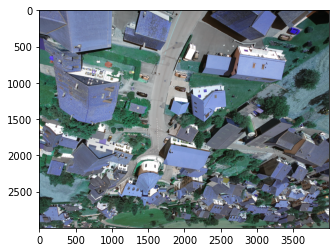

Resulting Similar Images
Match 0.9999999999999999
/content/drive/My Drive/Small_Village_2/IMG_7742.JPG


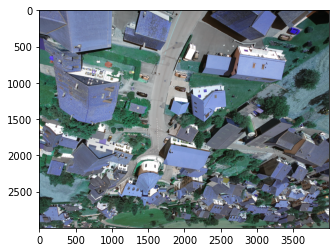

Match 0.7959532688413697
/content/drive/My Drive/Small_Village_2/IMG_7733.JPG


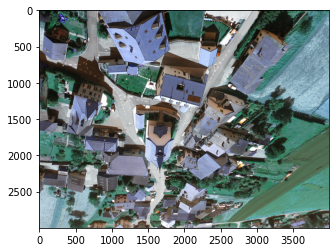

Match 0.7943759149466804
/content/drive/My Drive/Small_Village_2/IMG_7746.JPG


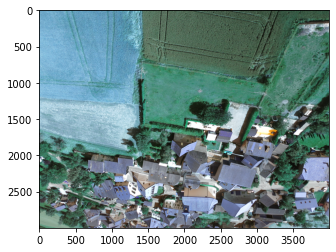

The Query Image
/content/drive/My Drive/Small_Village_2/IMG_7733.JPG


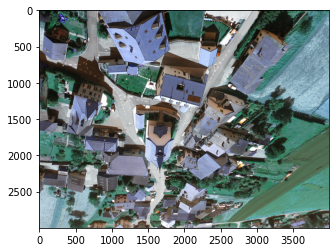

Resulting Similar Images
Match 1.0
/content/drive/My Drive/Small_Village_2/IMG_7733.JPG


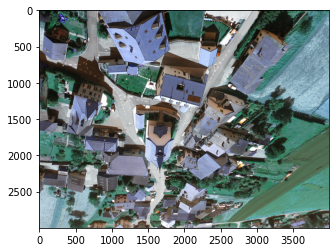

Match 0.8366850282921551
/content/drive/My Drive/Small_Village_2/IMG_7732.JPG


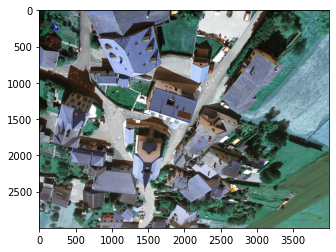

Match 0.8249857818283872
/content/drive/My Drive/Small_Village_2/IMG_7744.JPG


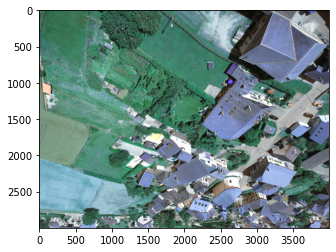

In [58]:
run()

# **Observation**

Gives good results, but it will be interesting to see, as examples becomes more complex with respect to resolution, would akaze,sift start to perform poorly than deeper cnns in-extracting more information.